In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
# from hssm.likelihoods import DDM
import itertools
import networkx as nx

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_context('talk')
sns.set_style('darkgrid')

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [ ]:
def clean_data(filename):
    # print(filename)

    try:
        data = pd.read_csv('data/' + filename)

        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['blocks.thisRepN']).reset_index(drop=True)

        if len(data) < 1400:
            raise TypeError('Incomplete Data')

        #Compute accuracy as True if number of response values are the same as number of stim values
        # print(data['stim'])
        data['accuracy'] = [True if (len(ast.literal_eval(data['stim'][i])) == len(ast.literal_eval(data['key_resp.rt'][i]))) else False for i in range(len(data))]


        data['node_type'] = ['Boundary' if data['node idx'][i] in [0, 4, 5, 9, 10, 14] else 'Non Boundary' for i in range(len(data))]

        data['rt'] = [np.mean(ast.literal_eval(data['key_resp.rt'][i])) if data['accuracy'][i] else np.NaN for i in range(len(data))]
        data['transition_type'] = ['cross cluster' if (data['node_type'] == 'Boundary')[i] & (data['node_type'].shift() == 'Boundary')[i] else 'within cluster' for i in range(len(data))]

        if data['participant'][0]%4 == 0:
            data['walk_length'] = 0
        elif data['participant'][0]%4 == 1:
            data['walk_length'] = 3
        elif data['participant'][0]%4 == 2:
            data['walk_length'] = 6
        else:
            data['walk_length'] = 1400

        data['trial'] = np.arange(len(data))
        
        #Count the lag to indicate when the same stimulus was seen previously. Lag = 1 means the previous trial had the same stimulus.
        lag_counter_dict = Counter()
        lag = []

        for s in data['stim']:
            lag.append(lag_counter_dict[s])
            lag_counter_dict.update(lag_counter_dict.keys())
            lag_counter_dict[s] = 1
            # print(lag_counter_dict)
        data['lag'] = lag
        
    except:
        return None
    data['num_keypress'] = [len(ast.literal_eval(data['stim'][i])) for i in range(len(data))]

    return data[['participant', 'trial', 'blocks.thisRepN', 'accuracy', 'walk_length', 'node_type', 'transition_type', 'rt', 'stim', 'num_keypress', 'lag']]


In [4]:
# data = pd.read_csv('data/3000_eb_03_2010-05-15_00h52.20.745.csv')



# Read the preprocessed data

In [5]:
df_clean_rt_outlier = pd.read_csv('df_clean_rt_outlier.csv')
# df_clean_rt_outlier

# Read the data files
Skip all these if done above

In [6]:
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('3') & f.endswith('csv')):
        data_files.append(f)

# Clean the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [7]:
df_clean = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)
df_clean['reset'] = 'False'
df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



for participant in df_clean.participant.unique():
    df_clean_participant = df_clean.loc[df_clean.participant == participant].reset_index(drop=True)
    shifted_df_clean_participant = df_clean_participant.shift()
    df_clean_participant.loc[((shifted_df_clean_participant['node_type'] == 'Non Boundary') & (df_clean_participant['node_type'] == 'Boundary')), 'node_transitions'] = 'nb_to_b'
    df_clean_participant.loc[((shifted_df_clean_participant['node_type'] == 'Non Boundary') & (df_clean_participant['node_type'] == 'Non Boundary')), 'node_transitions'] = 'nb_to_nb'
    df_clean_participant.loc[((shifted_df_clean_participant['node_type'] == 'Boundary') & (df_clean_participant['node_type'] == 'Non Boundary')), 'node_transitions'] = 'b_to_nb'
    df_clean_participant.loc[((shifted_df_clean_participant['node_type'] == 'Boundary') & (df_clean_participant['node_type'] == 'Boundary')), 'node_transitions'] = 'b_to_b'
    df_clean_participant['count_so_far'] = df_clean_participant.groupby(['stim']).cumcount()
    df_clean_participant['specific_transition'] = shifted_df_clean_participant['stim'] + '->' + df_clean_participant['stim']
    df_clean_participant['transition_experience'] = df_clean_participant.groupby(['specific_transition']).cumcount()
    df_clean.loc[df_clean.participant == participant, 'node_transitions'] = df_clean_participant['node_transitions'].values
    df_clean.loc[df_clean.participant == participant, 'count_so_far'] = df_clean_participant['count_so_far'].values
    df_clean.loc[df_clean.participant == participant, 'transition_experience'] = df_clean_participant['transition_experience'].values
    


df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'blocks.thisRepN', 'walk_length', 'node_type', 'transition_type', 'num_keypress']).median().reset_index()

df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

df_clean_rt_outlier['condition'] = df_clean_rt_outlier['walk_length']
df_clean_rt_outlier['log_rt'] = np.log(df_clean_rt_outlier['rt'].values)
df_clean_rt_outlier['log_rt_standardized'] = stat.zscore(df_clean_rt_outlier['log_rt'])
df_clean_rt_outlier['normalized_rt'] = df_clean_rt_outlier['rt'].values/np.max(df_clean_rt_outlier['rt'].values)
df_clean_rt_outlier['normalized_logrt'] = df_clean_rt_outlier['log_rt'].values/np.max(df_clean_rt_outlier['log_rt'].values)
df_clean_rt_outlier['log_trials'] = np.log(df_clean_rt_outlier.trial)
df_clean_rt_outlier['log_blocks'] = np.log(df_clean_rt_outlier['blocks.thisRepN'] + 1)


# Plot Accuracies

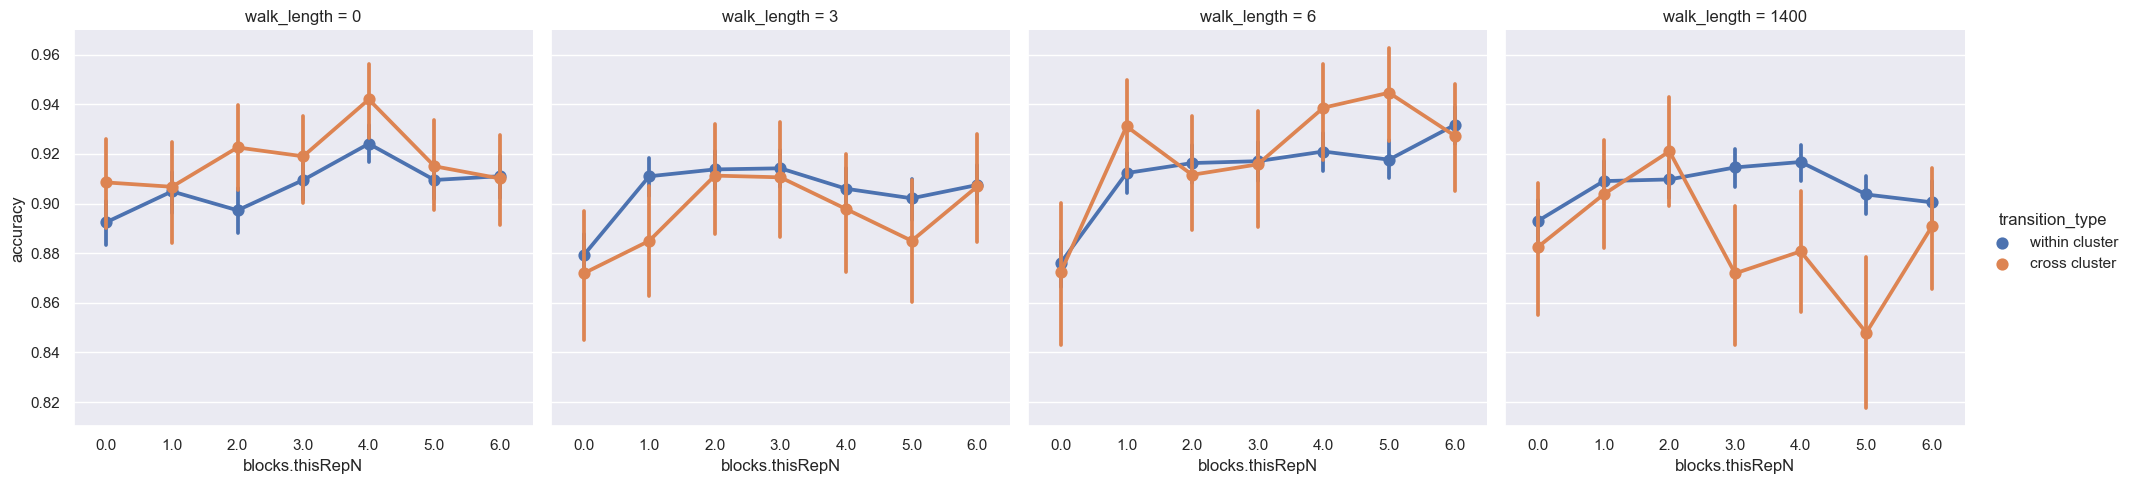

In [154]:
sns.set_context('paper')
sns.set_theme()
sns.catplot(y = 'accuracy', 
            x = 'blocks.thisRepN', col = 'walk_length', hue = 'transition_type',
            kind = 'point',
            data=df_clean)


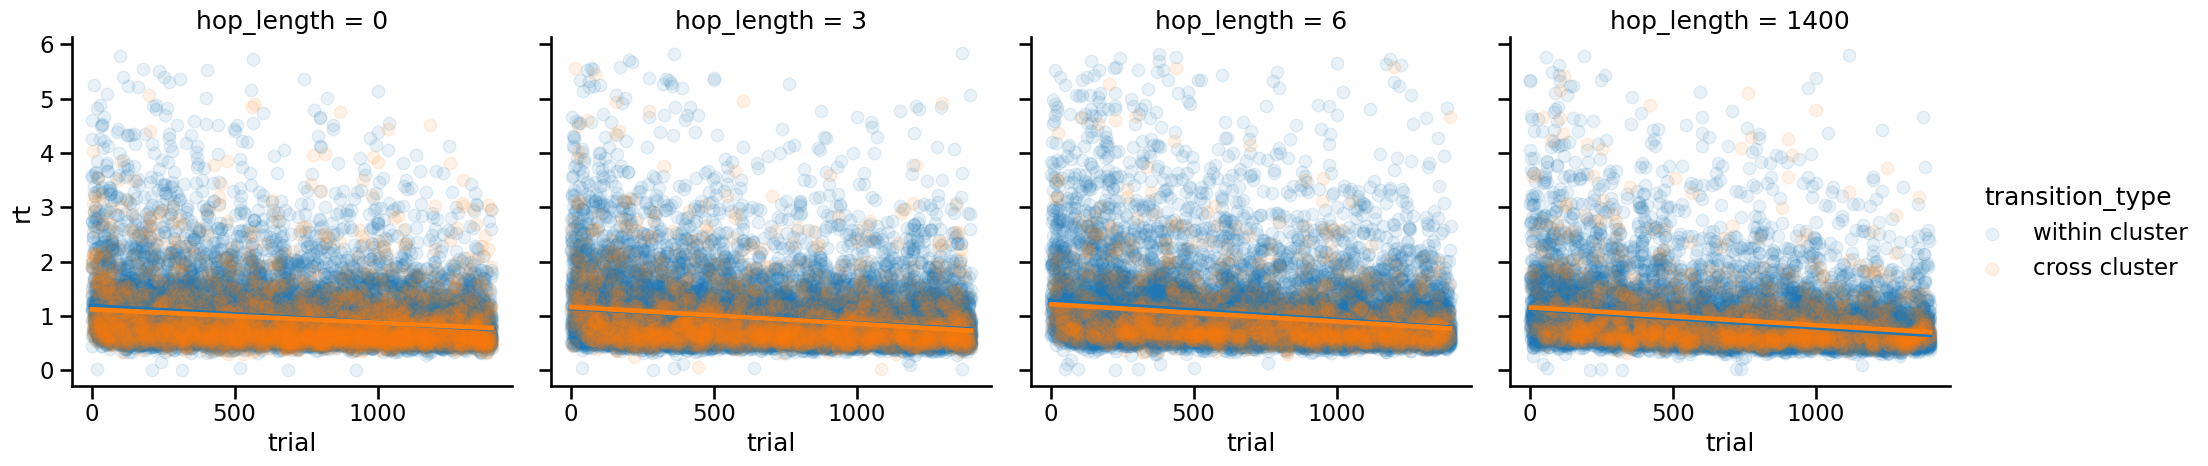

In [6]:
sns.lmplot(y = 'rt', 
            x = 'trial', col = 'walk_length', hue = 'transition_type',
            data=df_clean_rt_outlier, scatter_kws={'alpha': 0.1})


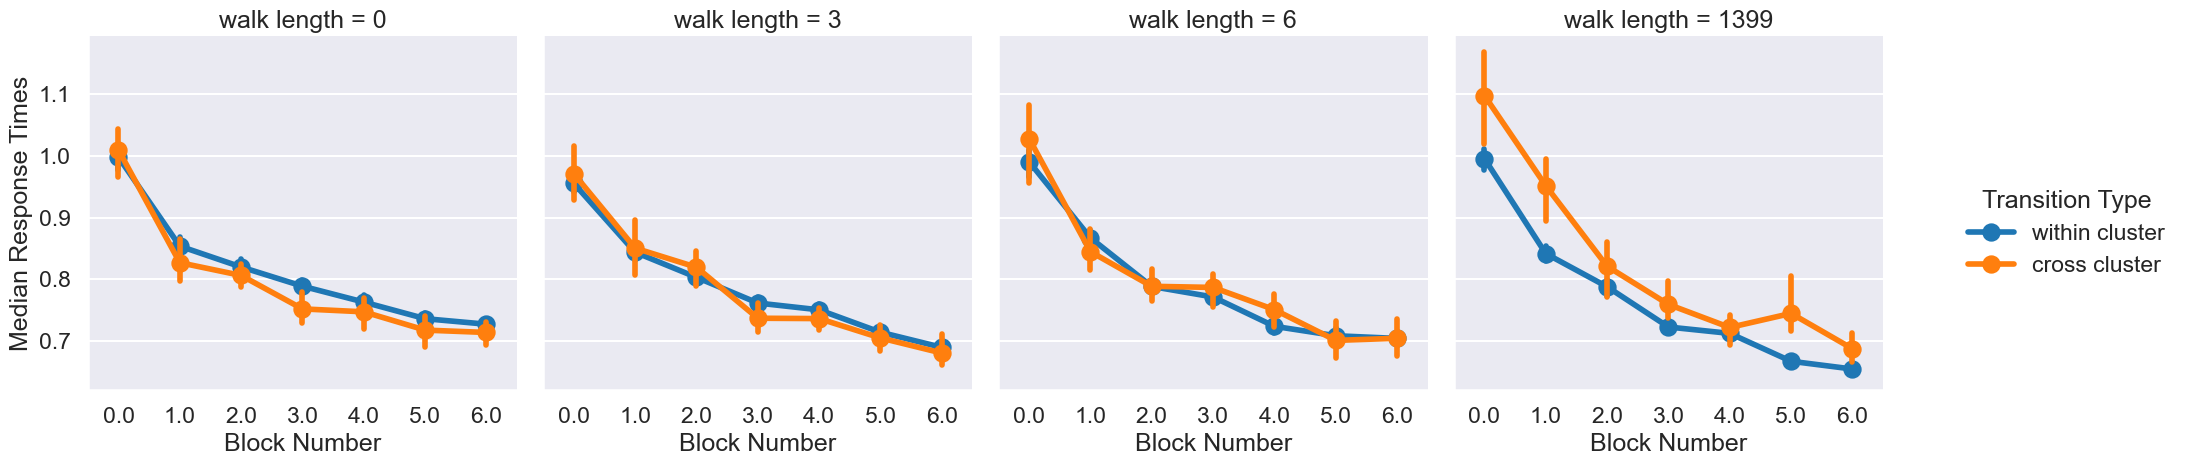

In [8]:
conditions = ['walk length = 0', 'walk length = 3', 'walk length = 6', 'walk length = 1399']
g = sns.catplot(y = 'rt', 
            x = 'blocks.thisRepN', hue = 'transition_type', col = 'walk_length',
            kind = 'point', estimator='median', margin_titles=True,
            data=df_clean_rt_outlier)
g.axes[0][0].set_ylabel('Median Response Times')
for i, ax in enumerate(g.axes[0]):
    ax.set_xlabel('Block Number')
    ax.set_title(conditions[i])
    
g._legend.set_title('Transition Type')

plt.savefig('figures/median_rts_transitiontype.png', dpi = 300, bbox_inches = 'tight', transparent = True)

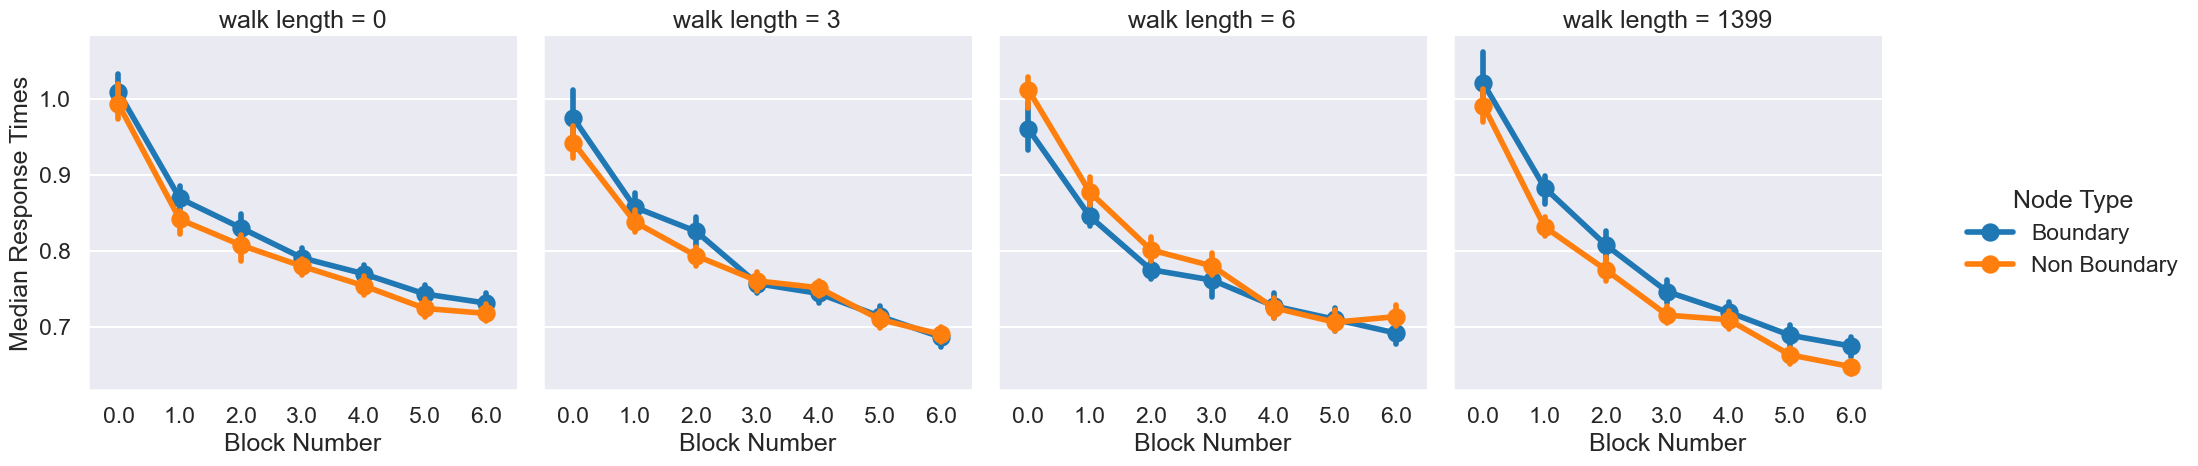

In [9]:
conditions = ['walk length = 0', 'walk length = 3', 'walk length = 6', 'walk length = 1399']
g = sns.catplot(y = 'rt', 
            x = 'blocks.thisRepN', hue = 'node_type', col = 'walk_length',
            kind = 'point', estimator='median', margin_titles=True,
            data=df_clean_rt_outlier)
g.axes[0][0].set_ylabel('Median Response Times')
for i, ax in enumerate(g.axes[0]):
    ax.set_xlabel('Block Number')
    ax.set_title(conditions[i])
    
g._legend.set_title('Node Type')

plt.savefig('figures/median_rts_nodetype.png', dpi = 300, bbox_inches = 'tight', transparent = True)

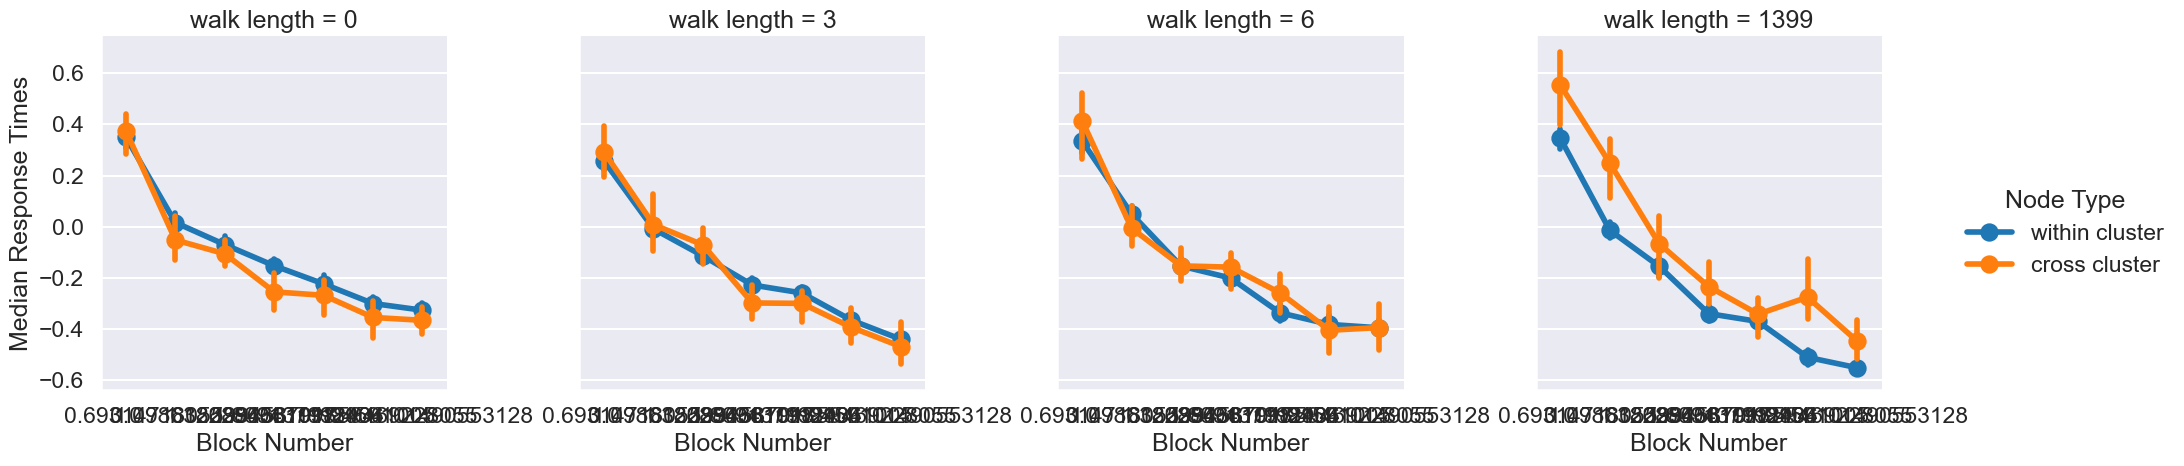

In [74]:
conditions = ['walk length = 0', 'walk length = 3', 'walk length = 6', 'walk length = 1399']
g = sns.catplot(y = 'log_rt_standardized', 
            x = 'log_blocks', hue = 'transition_type', col = 'walk_length',
            kind = 'point', estimator='median', margin_titles=True,
            data=df_clean_rt_outlier)
g.axes[0][0].set_ylabel('Median Response Times')
for i, ax in enumerate(g.axes[0]):
    ax.set_xlabel('Block Number')
    ax.set_title(conditions[i])
    
g._legend.set_title('Node Type')

# plt.savefig('figures/median_rts_nodetype.png', dpi = 300, bbox_inches = 'tight', transparent = True)

In [68]:
# df_clean_rt_outlier['normalized_logrt']

(-4.0, 4.0)

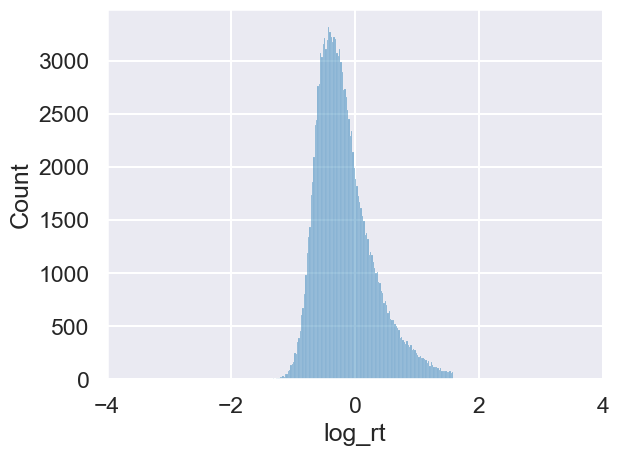

In [71]:
sns.histplot(df_clean_rt_outlier.log_rt, alpha = 0.5) 
# sns.histplot(df_clean_rt_outlier.log_rt_standardized, alpha = 0.5)
# sns.histplot(df_clean_rt_outlier.normalized_logrt, alpha = 0.5)

plt.xlim((-4, 4))

In [40]:
df_clean_rt_outlier[['transition_type', 'walk_length', 'node_type',  'rt']].groupby(by = ['transition_type','node_type', 'walk_length']).describe().iloc()[:, [1, 2, 5]].round(3).to_latex(buf = 'tables/rt-stats.txt', float_format="%.3f")

In [41]:
def model_def(df_clean_rt_outlier):
    # filtered = df_clean_rt_outlier.loc[(((df_clean_rt_outlier['node_transitions'] == 'nb_to_b') | (df_clean_rt_outlier['node_transitions'] == 'nb_to_nb')) & (df_clean_rt_outlier.accuracy == 1) & (df_clean_rt_outlier.reset == 'False'))]
    
    ppt, mn_ppt = df_clean_rt_outlier.participant.factorize()
    reset, mn_reset = df_clean_rt_outlier.reset.factorize()
    tt, mn_tt = df_clean_rt_outlier.transition_type.factorize()    
    nkp, mn_nkp = df_clean_rt_outlier.num_keypress.factorize()
    cond, mn_cond = df_clean_rt_outlier.condition.factorize()
    
    # nt, mn_nt = filtered.node_type.factorize()
    ntt, mn_ntt = df_clean_rt_outlier.node_transition_type.factorize()
    ntr, mn_ntr = df_clean_rt_outlier.node_transitions.factorize()
    
    # block = df_clean_rt_outlier['blocks.thisRepN'].values+1
    trial = df_clean_rt_outlier['trial'].values+1
    log_lag = np.log(df_clean_rt_outlier.lag+1)
    lag = df_clean_rt_outlier.lag+1
    experience = df_clean_rt_outlier['count_so_far'].values
    transition_experience = df_clean_rt_outlier['transition_experience'].values
    # cond, mn_cond = df_clean_rt_outlier.condition.factorize()

    coords = {"participant": mn_ppt,
              "condition": mn_cond,
              # "reset": mn_reset,
              "nkp": mn_nkp,
              # "node_transitions": mn_ntr,
              # "node_transition_type": mn_ntt,
              "transition_type": mn_tt,
             }
    # BoundNormal = pm.Bound(pm.Normal, lower=-1, upper = 1)

    with pm.Model(coords = coords, check_bounds = False) as asymptote_model:
        # block_idx = pm.MutableData('block', block, dims = "obs_id")
        trial_idx = pm.MutableData('trials', trial, dims = "obs_id")
        # log_lag_idx = pm.MutableData('log_lag', log_lag, dims = "obs_id")
        lag_idx = pm.MutableData('lag', lag, dims = "obs_id")
        # experience_idx = pm.MutableData('experience', experience, dims = "obs_id")
        # transition_experience_idx = pm.MutableData('transition_experience', transition_experience, dims = "obs_id")
        
        
        participant_idx = pm.MutableData('participant_idx', ppt, dims = "obs_id")
        transition_type_idx = pm.MutableData('transition_type_idx', tt, dims = "obs_id")
        # node_transition_type_idx = pm.MutableData('node_transition_type_idx', ntt, dims = "obs_id")
        # node_transitions_idx = pm.MutableData('node_transitions_idx', ntr, dims = "obs_id")
        
        # node_type_idx = pm.MutableData('node_type_idx', nt, dims = "obs_id")
        
        # condition_idx = pm.MutableData('condition_idx', cond, dims = "obs_id")
        # reset_idx = pm.MutableData("reset_idx", reset, dims = "obs_id")
        nkp_idx = pm.MutableData("nkp_idx", nkp, dims = "obs_id")

        
        # beta_participant = pm.Normal('beta_participant', mu = 0, sigma = 0.1, dims = "participant")
        # asymptote_trial_nt = pm.Normal('asymptote_trial_nt', -0.2, 0.2, dims = 'node_type')
        # asymptote_trial_tt = pm.Normal('asymptote_trial_tt', asymptote_trial_nt, 0.2, dims = 'transition_type')

        # nodetype_effect = pm.Deterministic('nodetype_effect', beta_trial_nodetype[node_type_idx], dims = 'obs_id')
        # beta_condition = pm.Normal('beta_condition', 0.005, 0.001, dims = "condition")
        # beta_condition_sigma = pm.Exponential('beta_condition_sigma', lam = 1)
        
        # beta_trial_ntr = pm.Uniform('beta_trial_ntr', 0.00001, 0.1, dims = ("node_transitions"))
        # beta_trial_ntr_sigma = pm.Exponential('beta_trial_ntr_sigma', 5, dims = "node_transitions")
        # beta_trial_ntr_participant = pm.TruncatedNormal('beta_trial_ntr_participant', mu = beta_trial_ntr, sigma = beta_trial_ntr_sigma, lower = 0.00001, upper = 0.1, dims = ("participant", "node_transitions"))
        beta_trial_tt = pm.Uniform('beta_trial_tt', 0.000001, 0.1, dims = ("transition_type"))
        # alpha_condition = pm.Normal('alpha_condition', mu = 0.5, sigma = 0.1, dims = "condition")
        # alpha_condition_sigma = pm.Exponential('alpha_condition_sigma', lam = 1)

        # alpha_ntr = pm.Normal('alpha_ntr', mu = 0.5, sigma = 0.5, dims = ('node_transitions'))
        # alpha_ntr_sigma = pm.Exponential('alpha_ntr_sigma', 3, dims = ('node_transitions'))
        # alpha_ntr_participant = pm.Normal('alpha_ntr_participant', mu = alpha_ntr, sigma = alpha_ntr_sigma, dims = ('participant', 'node_transitions'))
        alpha_tt = pm.Normal('alpha_tt', mu = 0.5, sigma = 0.2, dims = ('transition_type'))
        
        # asymptote_condition = pm.Normal("asymptote_condition", mu = 0, sigma = 0.3, dims = "condition")
        # asymptote_condition_sigma = pm.Exponential("asymptote_condition_sigma", lam = 1)
        # asymptote_ntr = pm.Normal('asymptote_ntr', mu = 0, sigma = 0.3, dims = ('node_transitions'))
        # asymptote_ntr_sigma = pm.Exponential('asymptote_ntr_sigma', 3, dims = "node_transitions")
        # asymptote_ntr_participant = pm.Normal('asymptote_ntr_participant', mu = asymptote_ntr, sigma= asymptote_ntr_sigma, dims = ('participant', 'node_transitions'))
        # asymptote_tt = pm.Normal('asymptote_tt', mu = 0, sigma = 0.3, dims = ('transition_type'))

        
        beta_lag = pm.Normal('beta_lag', 0, 1)
        nkp_trial = pm.Normal('nkp_trial', 0, 0.1, dims = "nkp")
        # beta_experience = pm.Normal('beta_experience', 0, 1)
        # beta_transition_experience = pm.Normal('beta_transition_experience', 0, 1)
        
#         participant_mu_alpha = pm.Normal('participant_mu_alpha', 0.5, 0.5)
#         participant_sigma_alpha = pm.Exponential('participant_sigma_alpha', lam = 1)
#         participant_intercept_alpha = pm.Normal('participant_intercept_alpha', mu = participant_mu_alpha, sigma = participant_sigma_alpha, dims = 'participant')

#         participant_mu_beta = pm.TruncatedNormal('participant_mu_beta', 0.01, 0.01, lower = 0.0001)
#         participant_sigma_beta = pm.Exponential('participant_sigma_beta', lam = 1)
#         participant_intercept_beta = pm.Normal('participant_intercept_beta', mu = participant_mu_beta, sigma = participant_sigma_beta, dims = 'participant')

        participant_mu_asymptote = pm.Normal('participant_mu_asymptote', 0, 0.3)
        participant_sigma_asymptote = pm.Exponential('participant_sigma_asymptote', lam = 1)
        participant_intercept_asymptote = pm.Normal('participant_intercept_asymptote', mu = participant_mu_asymptote, sigma = participant_sigma_asymptote, dims = 'participant')
        

        
#         if df_clean_rt_outlier.condition.unique() == 3 or df_clean_rt_outlier.condition.unique() == 6:
            
#             # reset_trial_mu = pm.Normal('reset_trial_mu', mu = 0, sigma = 0.5)
#             # reset_trial_sigma = pm.Exponential('reset_trial_sigma', lam = 3)
#             # # reset_trial_z = pm.Normal('reset_trial_z', mu = 0, sigma = 1, dims = "reset")
#             reset_trial = pm.Normal('reset_trial', 0, 0.2, dims = "reset")

#             mu_logrt = pm.Deterministic('mu_logrt', 
#                                         participant_intercept[participant_idx] + 
#                                         nkp_trial[nkp_idx] + reset_trial[reset_idx] + 
#                                         # asymptote_trial_tt[transition_type_idx] + 
#                                         # asymptote_trial_nt[node_type_idx] + 
                                        
#                                         # asymptote_trial[participant_idx] + 
#                                         alpha_tt[transition_type_idx] + 
#                                         beta_trial_tt[transition_type_idx]*trial_idx + 
#                                         # alpha_nt[node_type_idx] + 
#                                         # beta_trial_nt[node_type_idx]*trial_idx + 
#                                         beta_lag*pm.math.log(lag_idx))            
#         else:
        mu_logrt = pm.Deterministic('mu_logrt', 
                                    participant_intercept_asymptote[participant_idx] + 
                                    nkp_trial[nkp_idx] + 
                                    # asymptote_tt[transition_type_idx] + 
                                    # asymptote_ntr[node_transitions_idx] +
                                    alpha_tt[transition_type_idx] - beta_trial_tt[transition_type_idx]*trial_idx +
                                    # alpha_nt[node_type_idx] + 
                                    # beta_trial_nt[node_type_idx]*trial_idx + 
                                    beta_lag*pm.math.log(lag_idx) 
                                    # beta_experience*experience_idx +
                                    # beta_transition_experience*transition_experience_idx
                                    
                                   )
    # mu_logrt = alpha_block[transition_type_idx]*block_idx**(-beta_block[transition_type_idx])

        # mu_logrt = intercept_trial + beta_trial*block_idx
        rt_sigma_intercept = pm.Exponential('rt_sigma_intercept', lam = 1)
        rt_sigma_slope = pm.TruncatedNormal('rt_sigma_slope', mu = 0, sigma = 0.1, lower=0.001)        
        rt_sigma = pm.Deterministic('rt_sigma', rt_sigma_intercept + rt_sigma_slope*trial_idx)
        # rt_sigma = pm.Exponential('rt_sigma', lam = 1)
        
        ## Constraints
        # penalty_multiplier = 100
        # beta_tt_con = pm.math.ge(beta_trial_tt, -0.005)
        # beta_tt_potential = pm.Potential('beta_tt_potential', pm.math.switch(beta_tt_con, 0, -(beta_tt_con**2*penalty_multiplier)))
        # beta_nt_con = pm.math.ge(beta_trial_nt, -0.005)
        # beta_nt_potential = pm.Potential('beta_nt_potential', pm.math.switch(beta_nt_con, 0, -(beta_nt_con**2*penalty_multiplier)))
        
        skewness = pm.TruncatedNormal('skewness', mu = 0, sigma = 3, lower = 0)
        # skewnes_slope = pm.Normal('skewness_slope', mu = 0, sigma = 0.1)
        # skewness = pm.Deterministic('skewness', skewness_intercept + skewness_slope*trial_idx)
        # nu_est = pm.Gamma('nu_est', 2, 0.1)
        # rt_lam = pm.Exponential('rt_lam', lam = 1)

        y_hat = pm.SkewNormal('y_hat', mu = mu_logrt, sigma = rt_sigma, alpha= skewness, observed = df_clean_rt_outlier.log_rt)

    return asymptote_model


In [42]:
models = {}
for c in [3, 6, 1400]:
    filtered = df_clean_rt_outlier.loc[((df_clean_rt_outlier.condition == c) &  (df_clean_rt_outlier.accuracy == 1) & (df_clean_rt_outlier.reset == False))]
    models[str(c)] = model_def(filtered)

In [50]:
G = pm.model_to_networkx(models['3'])
with open('figures/model_graph.txt', 'w') as text_file:
    text_file.write(nx.to_latex(G))

In [166]:
# block_cutoff = 4
# g = sns.displot(x = 'rt', hue='transition_type', col='walk_length', 
#              col_wrap=2, 
#              data = df_clean_rt_outlier.loc[df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff])
# walk_lengths = [0, 3, 6, 1400]
# for i in range(4):
#     g.axes[i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['transition_type'] == 'cross cluster') & (df_clean_rt_outlier['walk_length'] == str(walk_lengths[i]))), 'rt']), 
#                       c = 'orange', ls = '--', alpha = 1)
    
#     g.axes[i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['transition_type'] == 'within cluster') & (df_clean_rt_outlier['walk_length'] == str(walk_lengths[i]))), 'rt']), 
#                       c = 'blue', ls = '--', alpha = 0.5)

#     # g.axes[0][i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['node_type'] == 'Boundary') & (df_clean_rt_outlier['walk_length'] == walk_lengths[i])), 'rt']), c = 'orange', ls = '--')
#     # g.axes[0][i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['node_type'] == 'Non Boundary') & (df_clean_rt_outlier['walk_length'] == walk_lengths[i])), 'rt']), c = 'blue', ls = '--')


In [165]:
# sns.catplot(y = 'rt', 
#             hue = 'reset', x = 'node_transition_type', col = 'walk_length', 
#             # row_order=['Non Boundary', 'Boundary'], margin_titles=True,
#             kind = 'box', estimator='median', col_wrap=2,
#             data=df_clean_rt_outlier)


In [199]:
pd.DataFrame({'1': ['N', 'Walk Length', 'Description'],
              '2': [29, 0, 'Chosen Randomly'],
              '3': [29, 3, 'Reset after 3 edges'],
              '6': [26, 6, 'Reset after 6 edges'],
              '1400': [29, 1400, 'No Reset'],              
             })

,1,2,3,6,1400
0,N,29,29,26,29
1,Walk Length,0,3,6,1400
2,Description,Chosen Randomly,Reset after 3 edges,Reset after 6 edges,No Reset


In [184]:
df_clean_rt_outlier.loc[df_clean_rt_outlier['walk_length'] == '1400', 'participant'].unique().shape

(29,)

In [164]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,walk_length,node_type,transition_type,rt,stim,num_keypress,lag,reset,node_transition_type
0,3000.0,0,0.0,True,0,Boundary,within cluster,1.367459,"('l', 'space')",2,0,True,Boundary within cluster
2,3000.0,2,0.0,True,0,Boundary,within cluster,1.377622,"('j', 'space')",2,0,True,Boundary within cluster
3,3000.0,3,0.0,True,0,Non Boundary,within cluster,1.171814,"('j', 'k')",2,0,True,Non Boundary within cluster
4,3000.0,4,0.0,True,0,Boundary,within cluster,1.230127,"('l', 'space')",2,4,True,Boundary within cluster
5,3000.0,5,0.0,True,0,Boundary,cross cluster,0.726496,"('l', 'space')",2,1,True,Boundary cross cluster
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158195,3127.0,1395,6.0,True,1400,Non Boundary,within cluster,0.553965,"('h',)",1,2,False,Non Boundary within cluster
158196,3127.0,1396,6.0,True,1400,Non Boundary,within cluster,0.407528,"('k',)",1,5,False,Non Boundary within cluster
158197,3127.0,1397,6.0,True,1400,Boundary,within cluster,0.553164,"('k', 'space')",2,5,False,Boundary within cluster
158198,3127.0,1398,6.0,True,1400,Boundary,cross cluster,0.605145,"('h', 'space')",2,106,False,Boundary cross cluster


In [87]:
df_clean_rt_outlier_median = df_clean_rt_outlier.loc[df_clean_rt_outlier['trial'] > 0].reset_index(drop=True).groupby(['participant', 'trial', 'transition_type', 'node_type', 'walk_length']).median(numeric_only=True).reset_index()
df_clean_rt_outlier_median_cross = df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'cross cluster'].reset_index(drop=True)
df_clean_rt_outlier_median_within = df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'within cluster'].reset_index(drop=True)
diff = df_clean_rt_outlier_median_cross.merge(df_clean_rt_outlier_median_within, on = ['participant', 'walk_length', 'blocks.thisRepN'])
# # # df_clean_rt_outlier_median_diff['diff'] = df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'cross cluster', 'rt'].values - df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'Non Boundary', 'rt'].values
# diff['rt_diff'] = diff['rt_x'] - diff['rt_y']
# diff

# df_clean_rt_outlier_median_cross_boundary = df_clean_rt_outlier_median.loc[((df_clean_rt_outlier_median['transition_type'] == 'cross cluster') & (df_clean_rt_outlier_median['node_type'] == 'Boundary'))].reset_index(drop=True)
# df_clean_rt_outlier_median_within_nonboundary = df_clean_rt_outlier_median.loc[((df_clean_rt_outlier_median['transition_type'] == 'within cluster') & (df_clean_rt_outlier_median['node_type'] == 'Boundary'))].reset_index(drop=True)
# diff = df_clean_rt_outlier_median_cross_boundary.merge(df_clean_rt_outlier_median_within_nonboundary, on = ['participant', 'blocks.thisRepN', 'walk_length'])
# diff['rt_diff'] = diff['rt_x'] - diff['rt_y']
# diff

In [90]:
df_clean_rt_outlier_median_cross

,participant,trial,transition_type,node_type,walk_length,blocks.thisRepN,accuracy,rt,lag
0,3000.0,5,cross cluster,Boundary,0,0.0,1.0,0.726496,1.0
1,3000.0,17,cross cluster,Boundary,0,0.0,1.0,0.899880,9.0
2,3000.0,20,cross cluster,Boundary,0,0.0,1.0,0.837338,6.0
3,3000.0,21,cross cluster,Boundary,0,0.0,1.0,0.728612,1.0
4,3000.0,22,cross cluster,Boundary,0,0.0,1.0,0.880767,3.0
...,...,...,...,...,...,...,...,...,...
17180,3127.0,1337,cross cluster,Boundary,1400,6.0,1.0,1.327587,9.0
17181,3127.0,1343,cross cluster,Boundary,1400,6.0,1.0,0.479992,22.0
17182,3127.0,1353,cross cluster,Boundary,1400,6.0,1.0,0.414666,11.0
17183,3127.0,1356,cross cluster,Boundary,1400,6.0,1.0,0.958276,20.0


In [88]:
diff

,participant,trial_x,transition_type_x,node_type_x,walk_length,blocks.thisRepN,accuracy_x,rt_x,lag_x,trial_y,transition_type_y,node_type_y,accuracy_y,rt_y,lag_y
0,3000.0,5,cross cluster,Boundary,0,0.0,1.0,0.726496,1.0,2,within cluster,Boundary,1.0,1.377622,0.0
1,3000.0,5,cross cluster,Boundary,0,0.0,1.0,0.726496,1.0,3,within cluster,Non Boundary,1.0,1.171814,0.0
2,3000.0,5,cross cluster,Boundary,0,0.0,1.0,0.726496,1.0,4,within cluster,Boundary,1.0,1.230127,4.0
3,3000.0,5,cross cluster,Boundary,0,0.0,1.0,0.726496,1.0,6,within cluster,Non Boundary,1.0,0.645334,0.0
4,3000.0,5,cross cluster,Boundary,0,0.0,1.0,0.726496,1.0,7,within cluster,Non Boundary,1.0,1.000822,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705680,3127.0,1398,cross cluster,Boundary,1400,6.0,1.0,0.605145,106.0,1393,within cluster,Non Boundary,1.0,0.604379,3.0
2705681,3127.0,1398,cross cluster,Boundary,1400,6.0,1.0,0.605145,106.0,1395,within cluster,Non Boundary,1.0,0.553965,2.0
2705682,3127.0,1398,cross cluster,Boundary,1400,6.0,1.0,0.605145,106.0,1396,within cluster,Non Boundary,1.0,0.407528,5.0
2705683,3127.0,1398,cross cluster,Boundary,1400,6.0,1.0,0.605145,106.0,1397,within cluster,Boundary,1.0,0.553164,5.0


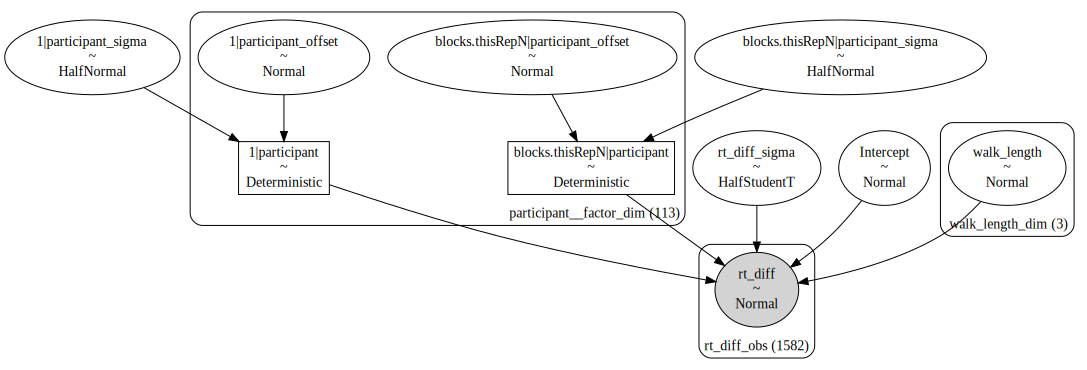

In [70]:
model = bmb.Model("rt_diff ~ walk_length + (blocks.thisRepN|participant)", data = diff)
model.build()
model.graph()

In [71]:
model

       Formula: rt_diff ~ walk_length + (blocks.thisRepN|participant)
        Family: gaussian
          Link: mu = identity
  Observations: 1582
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0139, sigma: 0.5529)
            walk_length ~ Normal(mu: [0. 0. 0.], sigma: [0.8975 0.8975 0.9314])
        
        Group-level effects
            1|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5529))
            blocks.thisRepN|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.196))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.1568)

# Fit a model or load a saved model. 

In [72]:
sample = model.fit(draws=1000, target_accept = 0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rt_diff_sigma, Intercept, walk_length, 1|participant_sigma, 1|participant_offset, blocks.thisRepN|participant_sigma, blocks.thisRepN|participant_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 318 seconds.


In [73]:
# # #For loading a saved model
# sample = az.from_netcdf('results/bayesian_model_0_medianrt')

In [74]:
coords = {'walk_length_dim': ['1400', '6', '3'], 
          # 'walk_length:transition_type_dim':['1400, within cluster', '6, within cluster', '3, within cluster'],
          # 'blocks.thisRepN:walk_length_dim':['1400', '6', '3'],
         }

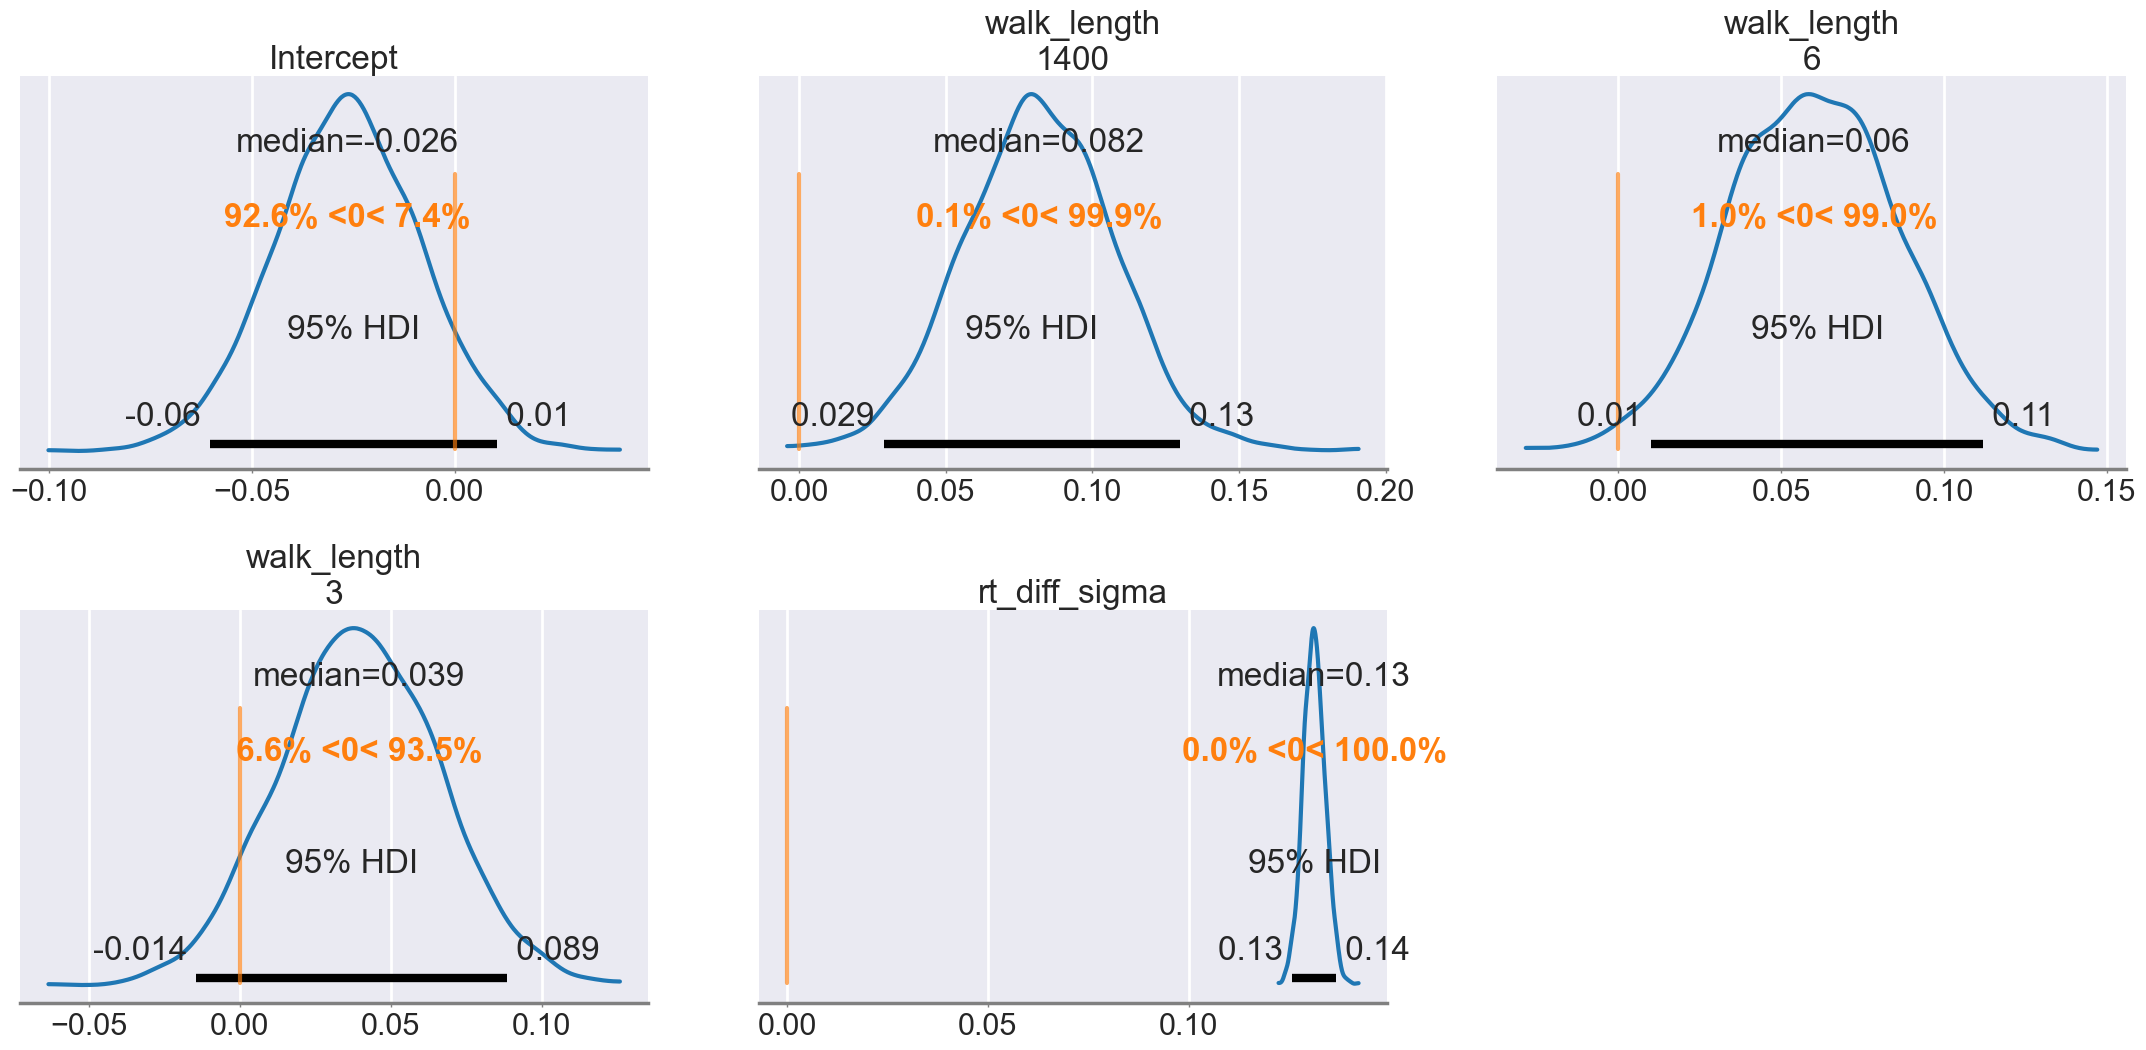

In [75]:
az.plot_posterior(sample, point_estimate='median', ref_val=0, hdi_prob=.95, var_names='~participant', filter_vars='like', coords = coords)
plt.tight_layout()
# plt.savefig('results/posteriors_bayesianmodel_0_params_medianrt.png', dpi = 600)

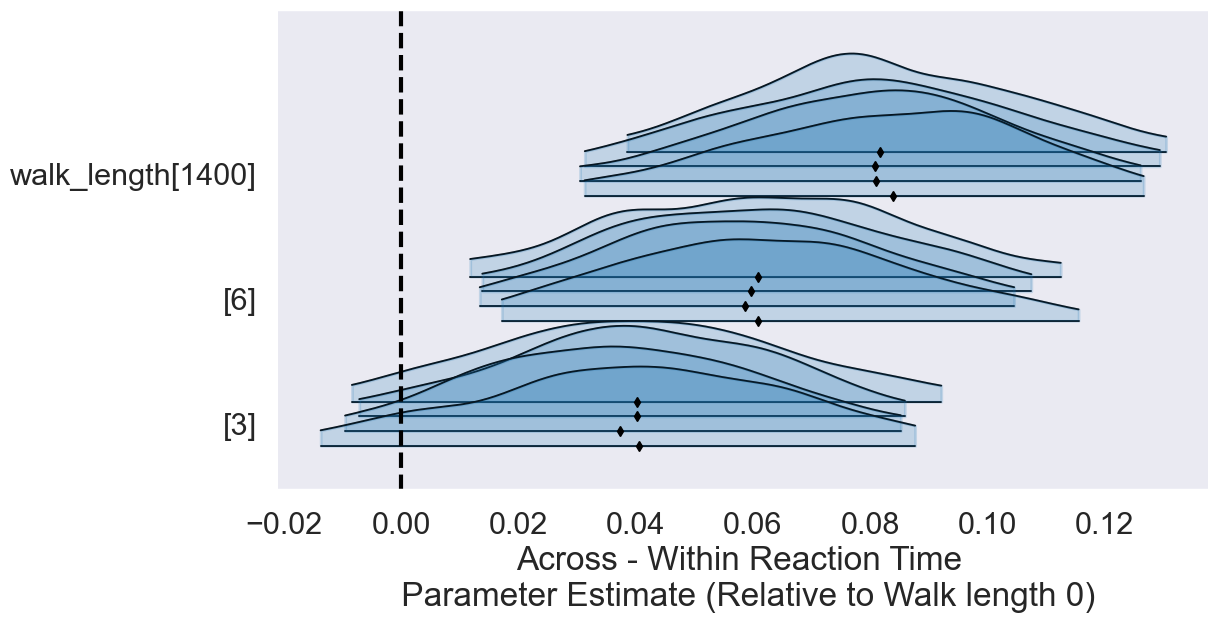

In [92]:
sns.set_context('poster')
g = az.plot_forest(sample, var_names=['~participant', '~Intercept', '~sigma'], filter_vars='like', kind = 'ridgeplot', ridgeplot_quantiles = [0.5], ridgeplot_alpha=0.2, ridgeplot_overlap=1, 
              coords = coords, textsize=10)
g[0].axvline(0, ls = '--', color = 'black')
g[0].set_xlabel('Across - Within Reaction Time \n Parameter Estimate (Relative to Walk length 0)')
plt.savefig('results/ridgeplot_bayesianmodel_blockbyppt_medianrtdiff.png', dpi = 600, bbox_inches = 'tight')

In [236]:
az.summary(sample, hdi_prob=.95, var_names = ['~participant'], filter_vars = 'like', coords=coords)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.016,0.018,-0.050,0.021,0.000,0.0,1391.0,2403.0,1.0
walk_length[1400],0.076,0.026,0.025,0.128,0.001,0.0,1547.0,2230.0,1.0
walk_length[6],0.035,0.027,-0.016,0.088,0.001,0.0,1562.0,2131.0,1.0
walk_length[3],0.032,0.026,-0.018,0.084,0.001,0.0,1501.0,2103.0,1.0
rt_diff_sigma,0.121,0.003,0.115,0.128,0.000,0.0,4068.0,2973.0,1.0


In [44]:
#Save model
az.to_netcdf(sample, 'results/bayesian_model_0_medianrt')

'results/bayesian_model_0_medianrt'

In [27]:
sample = az.from_netcdf('results/bayesian_model_0_rt')
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.834,0.038,0.767,0.909,0.001,0.001,710.0,1218.0,1.00
reset[True],0.047,0.005,0.038,0.056,0.000,0.000,4718.0,2619.0,1.00
lag,0.002,0.000,0.002,0.002,0.000,0.000,5155.0,2797.0,1.00
blocks.thisRepN,-0.060,0.006,-0.071,-0.050,0.000,0.000,633.0,1164.0,1.00
walk_length[1400],0.119,0.054,0.017,0.223,0.002,0.002,603.0,972.0,1.01
...,...,...,...,...,...,...,...,...,...
"num_keypress|participant[2, 3123.0]",0.322,0.032,0.264,0.379,0.000,0.000,5804.0,3187.0,1.00
"num_keypress|participant[2, 3124.0]",0.213,0.030,0.159,0.269,0.000,0.000,5695.0,2714.0,1.00
"num_keypress|participant[2, 3125.0]",0.316,0.029,0.260,0.369,0.000,0.000,5811.0,3258.0,1.00
"num_keypress|participant[2, 3126.0]",0.225,0.033,0.164,0.287,0.000,0.000,4981.0,2736.0,1.00


# Simulations

In [171]:
df_entropy = pd.read_csv('results/3module_SRTCM_entropies.csv')
# params = list(itertools.product([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9], [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9], ['walk', 'hop'], [1, 2, 3, 4, 5, 6]))
df_entropy.rename(columns={'param_a':'alpha', 'param_b':'gamma', 'walk_length':'walk length'}, inplace=True)
# df_entropy['node'] = np.tile(np.arange(15), 100*len(params))
df_entropy["node type"] = ["boundary" if x in [0, 4, 5, 9, 10, 14] else "Non Boundary" for x in pd.to_numeric(df_entropy["node"])]
df_entropy_mean = df_entropy.groupby(['alpha', 'gamma', 'walk length', 'iteration', 'node type']).mean().reset_index()
df_entropy_boundary = df_entropy_mean.loc[df_entropy_mean['node type'] == 'boundary'].reset_index(drop=True)
df_entropy_nonboundary = df_entropy_mean.loc[df_entropy_mean['node type'] != 'boundary'].reset_index(drop=True)
df_entropy_boundary['entropy_diff'] = df_entropy_boundary['entropy'] - df_entropy_nonboundary['entropy']
df_entropy_boundary.loc[df_entropy_boundary['walk length'] == 1000, 'walk length'] = 1400
df_entropy_boundary.loc[df_entropy_boundary['walk length'] == 1, 'walk length'] = 0

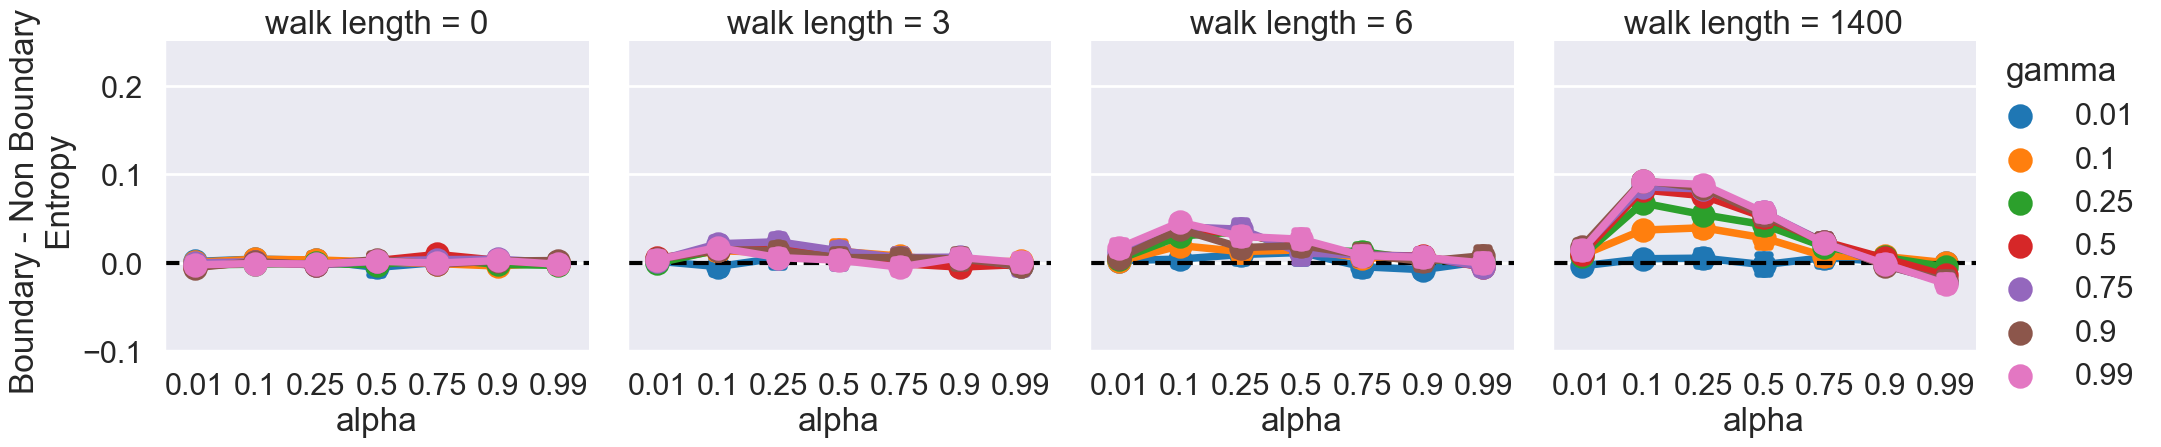

In [172]:
sns.set_context('poster')
g = sns.catplot(x = 'alpha', y = 'entropy_diff', hue = 'gamma', 
                kind = 'point', col = 'walk length', capsize = 0.2,
                data = df_entropy_boundary.loc[df_entropy_boundary['walk length'].notna()])

g.set_ylabels('Boundary - Non Boundary \n Entropy')
g.set(ylim=(-0.1, 0.25))
for column in range(4):
    g.axes[0][column].axhline(y = 0, ls = '--', color = 'black')
plt.savefig('results\SR_entropydiff_prediction.png', dpi = 300, bbox_inches = 'tight')


In [22]:
modular_graph = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])
SR = np.zeros((4, 15, 15))
for i, w in enumerate([1, 4, 6, 1000]):
    SR[i] = run_SR(random_walk(modular_graph, hop_step=w), modular_graph, 0.2, 0.05, plot=False)


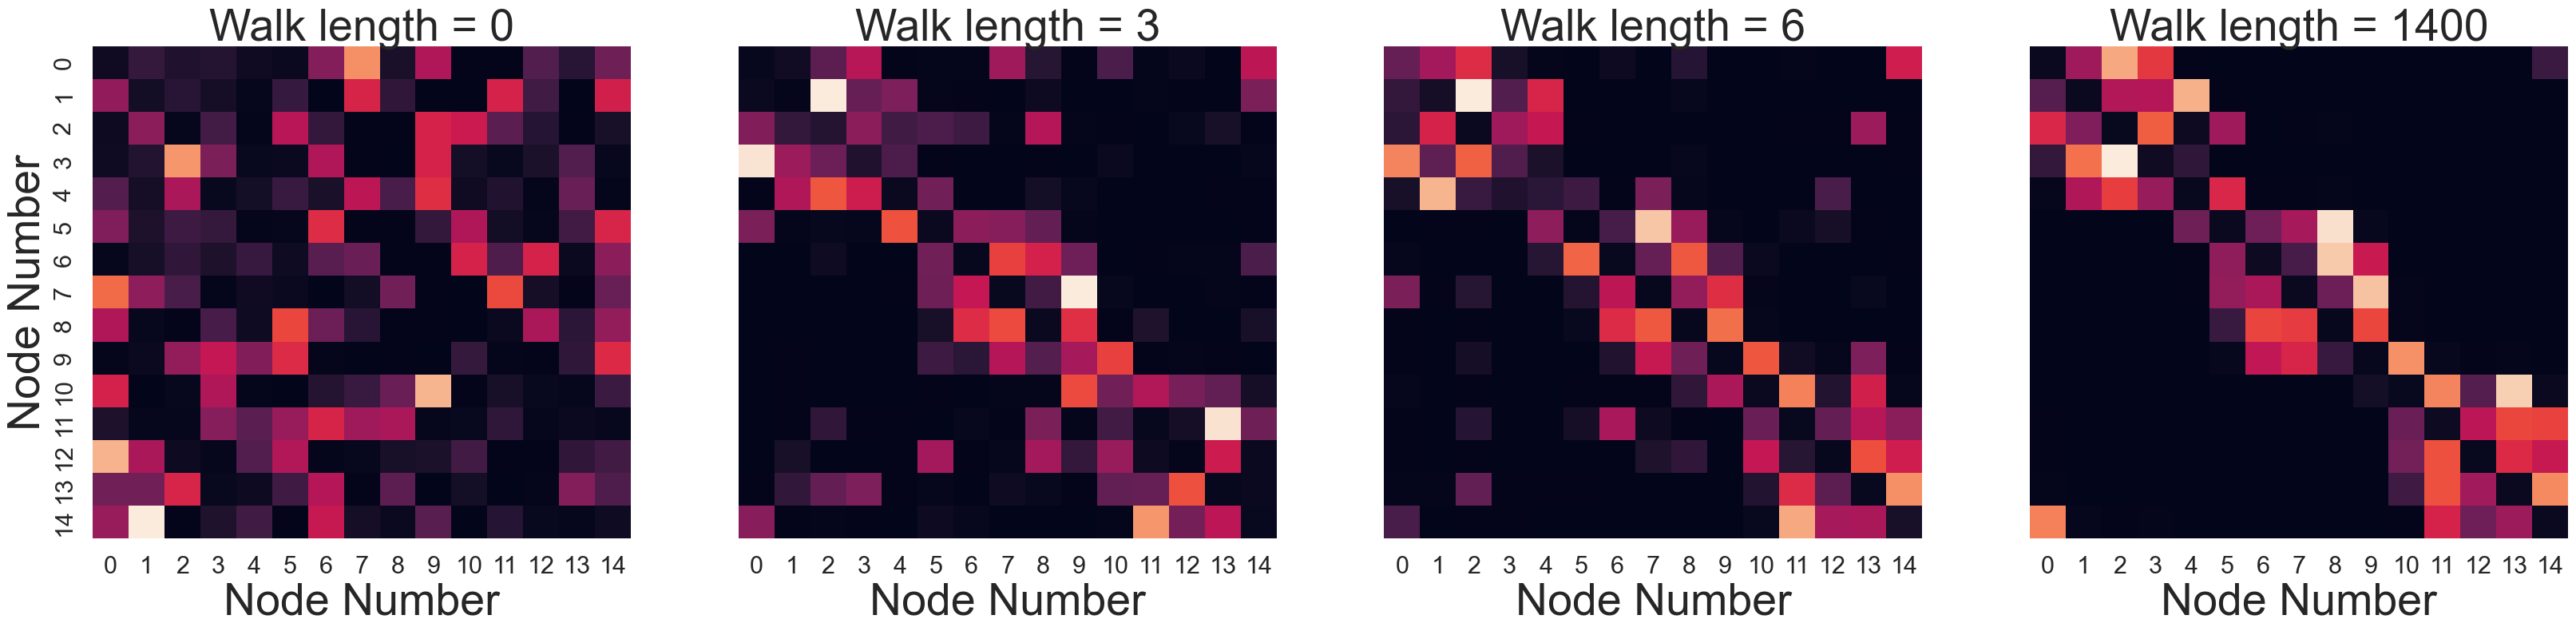

In [25]:
sns.set_context('poster')
walks = [0, 3, 6, 1400]
fig, ax = plt.subplots(1, 4, figsize = (40, 8))
for i, a in enumerate(ax):
    sns.heatmap(SR[i], ax = a, cbar = False)#cbar_kws = dict(use_gridspec=False,location="top"))
    # if i < 3:
    #     sns.heatmap(SR[i], ax = a, cbar = False)
    # else:
    #     sns.heatmap(SR[i], ax = a)        
    if i>0:
        a.set_yticks([])
    else:
        a.set_ylabel('Node Number', fontsize = 40)

    a.set_xlabel('Node Number', fontsize = 40)
        
    a.set_title(f'Walk length = {walks[i]}', fontsize = 40)
plt.savefig('results/SR_matrix_rep.png', dpi = 300, bbox_inches = 'tight')

In [12]:
modular_graph = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])


In [13]:
import networkx as nx


In [14]:
G = nx.DiGraph()
G.add_nodes_from(np.arange(5))
G.add_edges_from([(0, 1), (1, 2), (2, 4), (4, 1), (1, 3)])
G

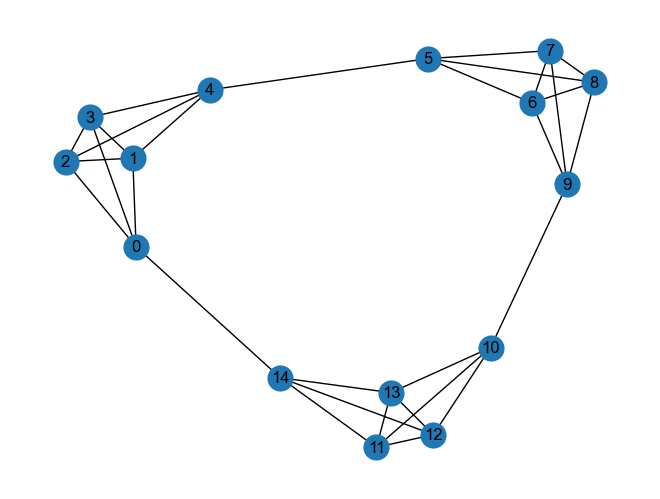

In [17]:
plot_graph(modular_graph)